In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import LabelEncoder
sns.set_theme()

In [2]:
df = pd.read_csv('./train.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
class PandasSimpleImputer(SimpleImputer):
    def fit(self, X, y=None):
        self.columns = X.columns
        return super().fit(X, y)

    def transform(self, X):
        return pd.DataFrame(super().transform(X), columns=self.columns)


In [4]:
def process(df, train=True):
    df0 = PandasSimpleImputer(strategy='most_frequent').fit_transform(df)
    df3 = df0['Cabin']
    df3 = pd.DataFrame(df3.str.split('/').to_list(), columns=['Cabin','Seat','Type'])
    df2 = pd.concat([df.drop('Cabin',axis=1),df3],axis=1)
    df2 = PandasSimpleImputer(strategy='most_frequent').fit_transform(df2)
    columns = [
        'HomePlanet',
        'CryoSleep',
        'Destination', 
        'RoomService', 
        'FoodCourt',
        'ShoppingMall',
        'Spa',
        'VRDeck',
        'VIP',
        'Cabin', 
        'Age',
        'Type',
        'Seat',
        # 'Transported', 
    ]
    if train:
        columns.append('Transported')
    df2 = df2[columns]
    df2.Seat = df2.Seat.astype(int)
    df2['CryoSleep'] = df2['CryoSleep'].astype(bool)
    df2['VIP'] = df2['VIP'].astype(bool)
    
    df2['HomePlanet'] = LabelEncoder().fit_transform(df2['HomePlanet'])
    df2['Destination'] = LabelEncoder().fit_transform(df2['Destination'])
    df2['Type'] = LabelEncoder().fit_transform(df2['Type'])
    df2['Cabin'] = LabelEncoder().fit_transform(df2['Cabin'])
    return df2

df2 = process(df)

![Alt text](image.png)

![Alt text](transformer_1-727x1024.webp)

![Alt text](Cuda.png)
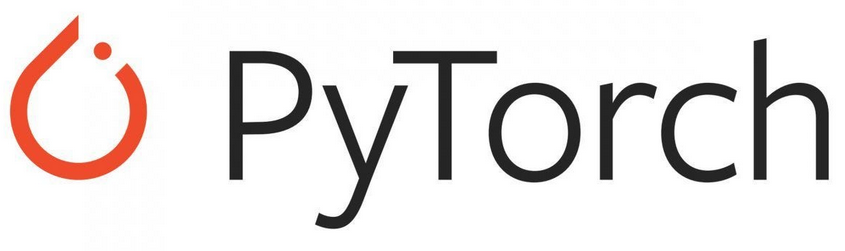
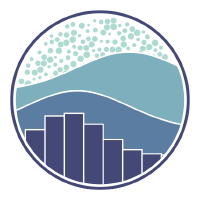

In [5]:
X = df2.drop('Transported', axis=1)
y = df2['Transported']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

clf = TabNetClassifier(
    n_d=16,
    n_a=16,
    n_steps=4,
    n_independent=2,
    n_shared=2,
    gamma=1.4)
clf.fit(
  np.array(X_train.values, dtype=np.float32), np.array(y_train.values, dtype=np.float32),
  eval_set=[(np.array(X_test.values, dtype=np.float32), np.array(y_test.values, dtype=np.float32))],
  patience=20,
)
prediction_rf = clf.predict(np.array(X_test.values, dtype=np.float32))

c:\Users\INFINITASIUM\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.65985 | val_0_auc: 0.76687 |  0:00:00s
epoch 1  | loss: 0.5596  | val_0_auc: 0.71737 |  0:00:01s
epoch 2  | loss: 0.51224 | val_0_auc: 0.72783 |  0:00:02s
epoch 3  | loss: 0.49154 | val_0_auc: 0.82385 |  0:00:02s
epoch 4  | loss: 0.47708 | val_0_auc: 0.82307 |  0:00:03s
epoch 5  | loss: 0.48126 | val_0_auc: 0.82023 |  0:00:04s
epoch 6  | loss: 0.46264 | val_0_auc: 0.84086 |  0:00:04s
epoch 7  | loss: 0.45791 | val_0_auc: 0.85127 |  0:00:05s
epoch 8  | loss: 0.45411 | val_0_auc: 0.8288  |  0:00:06s
epoch 9  | loss: 0.44767 | val_0_auc: 0.83887 |  0:00:06s
epoch 10 | loss: 0.44302 | val_0_auc: 0.84525 |  0:00:07s
epoch 11 | loss: 0.44598 | val_0_auc: 0.85716 |  0:00:07s
epoch 12 | loss: 0.44851 | val_0_auc: 0.86254 |  0:00:08s
epoch 13 | loss: 0.43906 | val_0_auc: 0.85937 |  0:00:09s
epoch 14 | loss: 0.4373  | val_0_auc: 0.86416 |  0:00:09s
epoch 15 | loss: 0.43599 | val_0_auc: 0.87086 |  0:00:10s
epoch 16 | loss: 0.43393 | val_0_auc: 0.86818 |  0:00:11s
epoch 17 | los

c:\Users\INFINITASIUM\AppData\Local\Programs\Python\Python311\Lib\site-packages\pytorch_tabnet\callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [6]:
print("Base Model Accuracy",accuracy_score(prediction_rf,y_test.astype(bool))*100)
print(classification_report(prediction_rf,y_test.astype(bool)))

Base Model Accuracy 82.18390804597702
              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83       457
         1.0       0.80      0.83      0.81       413

    accuracy                           0.82       870
   macro avg       0.82      0.82      0.82       870
weighted avg       0.82      0.82      0.82       870



In [7]:
def get_pred_df(df):
    rdf = pd.DataFrame(np.array([df.PassengerId,clf.predict(np.array(process(df,train=False).values, dtype=np.float32))]).transpose(1,0), columns=['PassengerId','Transported'])
    rdf['Transported'] = rdf['Transported'].astype(bool)
    return rdf

In [8]:
tdf = pd.read_csv('./test.csv')
get_pred_df(tdf).to_csv('submit.csv',index=False)

<Axes: xlabel='Cabin', ylabel='count'>

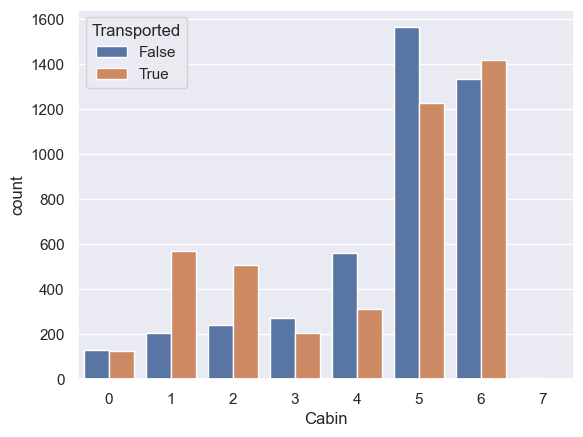

In [9]:
sns.countplot(x='Cabin', hue='Transported', data=df2)

<Axes: xlabel='Seat', ylabel='Density'>

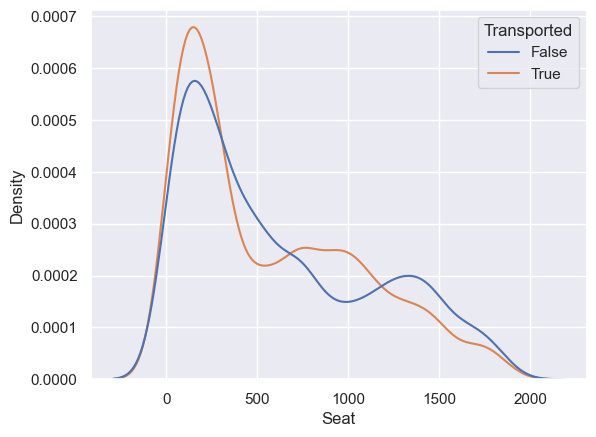

In [10]:
sns.kdeplot(df2, x='Seat', hue='Transported')

<Axes: xlabel='HomePlanet', ylabel='count'>

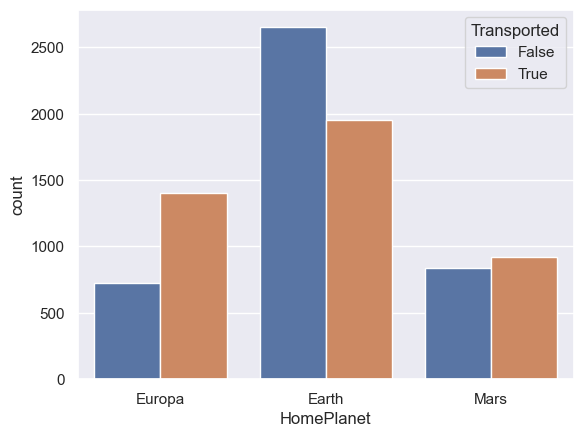

In [11]:
sns.countplot(df, x='HomePlanet', hue='Transported')

<Axes: xlabel='HomePlanet', ylabel='Age'>

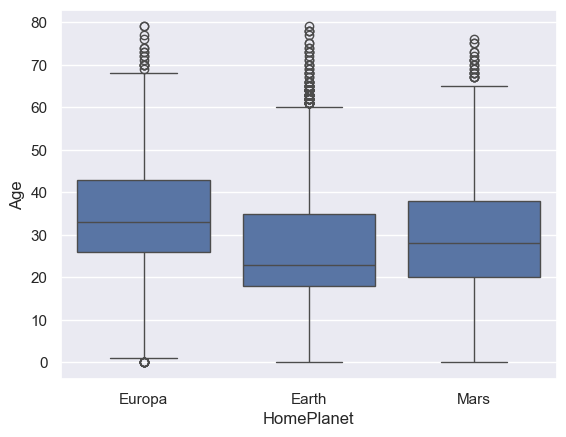

In [12]:
sns.boxplot(df, x='HomePlanet', y='Age')

<Axes: xlabel='HomePlanet', ylabel='Count'>

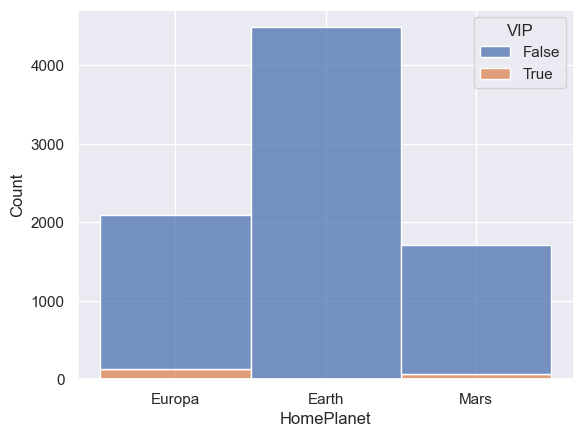

In [13]:
sns.histplot(df, x='HomePlanet', hue='VIP', multiple='stack')

<Axes: xlabel='HomePlanet', ylabel='Count'>

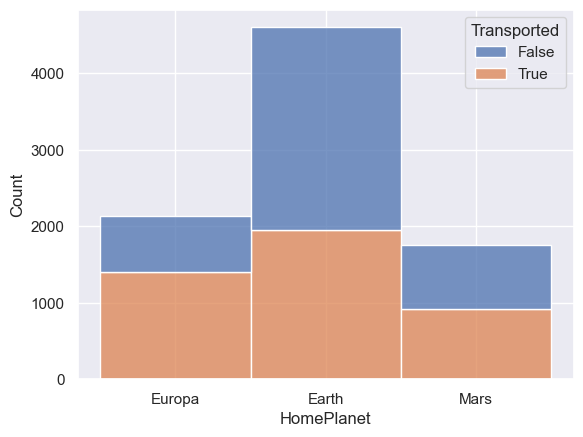

In [14]:
sns.histplot(df, x='HomePlanet', hue='Transported', multiple='stack')

<Axes: xlabel='CryoSleep_True', ylabel='Count'>

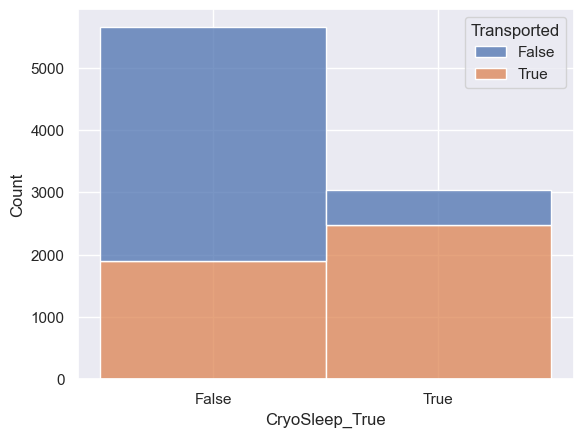

In [15]:
data  = pd.get_dummies(df[['CryoSleep','Transported']], columns=['CryoSleep'])
data.CryoSleep_True = data.CryoSleep_True.astype(str)
sns.histplot(data, x='CryoSleep_True', hue='Transported', multiple='stack')

<Axes: xlabel='Destination', ylabel='count'>

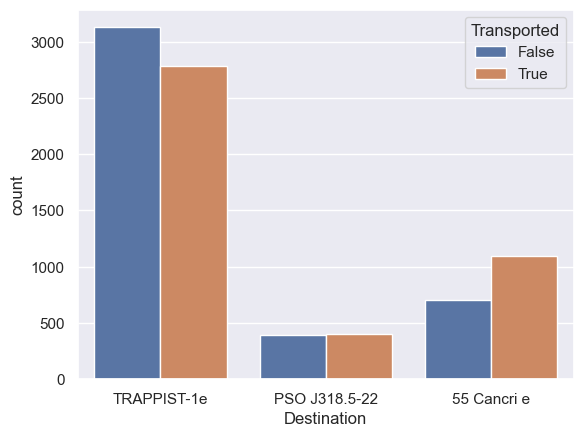

In [16]:
sns.countplot(df, x='Destination', hue='Transported')

<Axes: xlabel='RoomService', ylabel='Density'>

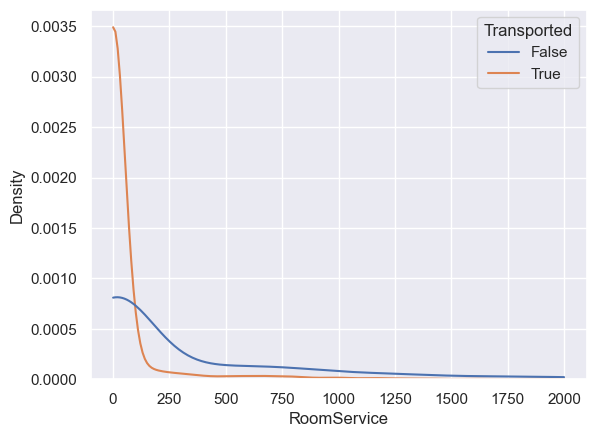

In [25]:
sns.kdeplot(df, x='RoomService', hue='Transported', clip=(0,2000))

<Axes: xlabel='VRDeck', ylabel='Density'>

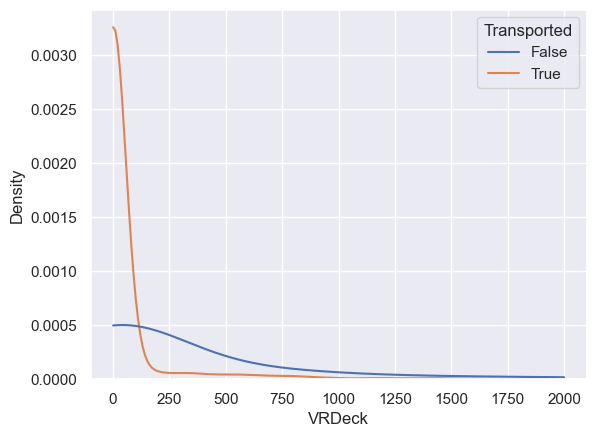

In [26]:
sns.kdeplot(df, x='VRDeck', hue='Transported', clip=(0,2000))

<Axes: xlabel='Spa', ylabel='Density'>

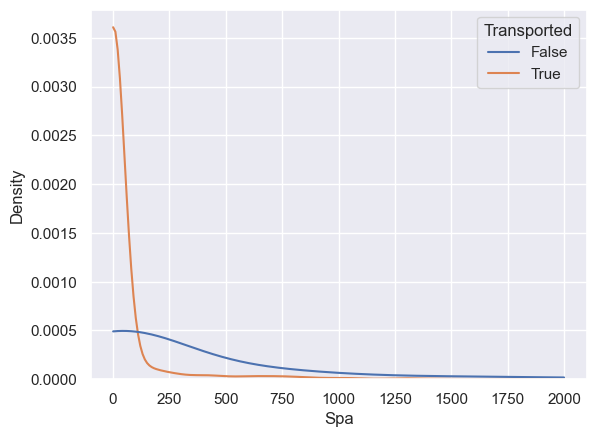

In [27]:
sns.kdeplot(df, x='Spa', hue='Transported', clip=(0,2000))

<Axes: xlabel='ShoppingMall', ylabel='Density'>

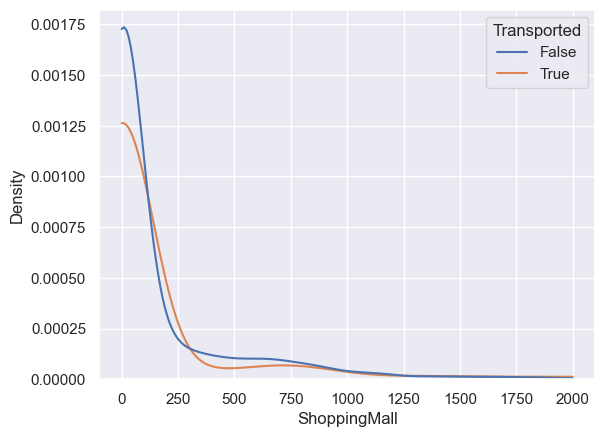

In [28]:
sns.kdeplot(df, x='ShoppingMall', hue='Transported', clip=(0,2000))

<Axes: xlabel='FoodCourt', ylabel='Density'>

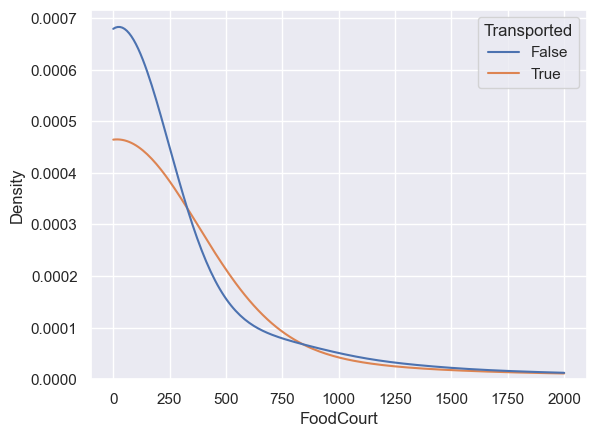

In [29]:
sns.kdeplot(df, x='FoodCourt', hue='Transported', clip=(0,2000))